In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from scipy import interpolate

import import_ipynb
import func_format
import func_analysis

from scipy import stats
import warnings
warnings.filterwarnings("ignore")

importing Jupyter notebook from func_format.ipynb
importing Jupyter notebook from func_analysis.ipynb


In [3]:
def extractusableint(modality, intcat, foldername, presentationnumber):
    if modality == 'female':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Female']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Female']
    elif modality == 'male':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
    elif modality == 'object':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
    elif modality == 'food':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Food']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Food']
    elif modality == 'social':
        usableint = np.ravel(foldername)[np.where((intcat == 'Male') | (intcat == 'Female'))]
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Female'])
    elif modality == 'nonsocial':
        usableint = np.ravel(foldername)[np.where((intcat == 'Object') | (intcat == 'Food'))]
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Food'])
    elif modality == 'panresponsive':
        usableint = np.ravel(foldername)[np.where((intcat == 'Object') | (intcat == 'Female') | (intcat == 'Male') | (intcat == 'Food'))]
        usablepresentationnumber = presentationnumber
    else:
        usableint = foldername
        usablepresentationnumber = presentationnumber
    
    return(usableint, usablepresentationnumber)

In [4]:
### make a function - all this to extract social and nonsocial behavior times that occur after first interaction

def socialnonsocial(file, behaviorpath, syncpath, intvalues):
    behavior = np.load(behaviorpath+file+'_bouttimes.npz')
    sync = np.loadtxt(syncpath+file+'_frameSync.csv')
    indintvalue = np.ravel(intvalues[intvalues[:,2] == file])
    activestart = sync[np.int(indintvalue[-4])]
    
    socialstartindex = np.unravel_index(np.argmin(np.abs(behavior['social']-activestart)), behavior['social'].shape)
    nonsocialstartindex = np.unravel_index(np.argmin(np.abs(behavior['nonsocial']-activestart)), behavior['nonsocial'].shape)
    
    if socialstartindex[1] == 1:
        socialbehavior = behavior['social'][socialstartindex[0]+1:]
    else:
        socialbehavior = behavior['social'][socialstartindex[0]:]
    if nonsocialstartindex[1] == 1:
        nonsocialbehavior = behavior['nonsocial'][nonsocialstartindex[0]+1:]
    else:
        nonsocialbehavior = behavior['nonsocial'][nonsocialstartindex[0]:]
    if socialbehavior[0,0] < activestart:
        socialbehavior[0,0] = activestart
    if nonsocialbehavior[0,0] < activestart:
        nonsocialbehavior[0,0] = activestart
        
    return(nonsocialbehavior, socialbehavior)

In [361]:
import sys
#### pull out firing rate distribution from 'social' and 'nonsocial' moments that start post first contact
#### compare firing distributions to find neurons that are significantly modulated by interactions
### can either compare firing rates directly (likely non parametric distribution test) or do an ROC curve

ratID = ['Amygdala6', 
         'Amygdala8',
         'Amygdala10', 
         'Amygdala11']
dates = ['13042019',
         '01102019',
         '27062020',
         '06072020']
ratlist = []
datelist = []
neuronlist = []
responselist = []
responselistmale = []
responselistfemale = []
responselistobject = []
neurontypelist = []
responselistfood = []
actualresponse = []
save2all = np.zeros(9)

analysistype = 'allneurons'
savepath = 'F:/ActivityModulationBehavior/'
func_format.foldercheck(savepath)

for r, rat in enumerate(ratID):
    date = dates[r]

    neuronpath = 'F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'
    behaviorpath = 'F:/'+rat+'/TrackingData/Behavior_analyzed/'+date+'/'
    syncpath = 'F:/'+rat+'/Electrophys/'+date+'/Sync/'
    configpath = 'F:/'+rat+'/Parameters_'+date+'.yml'


    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)

    intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)
    intvalues = intvalues[np.where((intvalues[:,0] == rat) & (intvalues[:,1] == date))]
    intcat = np.ravel(intcat)

    responseprofile = np.loadtxt('F:/ResponseType_BLAday1_4rats/responseprofile.csv', delimiter = ',', dtype = str)
    responseprofile = responseprofile[np.where((responseprofile[:,0] == rat) & (responseprofile[:,1] == date))]
    
    try:
        neurondir = os.listdir(neuronpath)
    except:
        continue
        
    for i, row in enumerate(responseprofile):
        neuronname = row[2]
        
        ratlist = np.append(ratlist, rat)
        datelist = np.append(datelist, date)
        neuronlist = np.append(neuronlist, neuronname)
        
        auROCscores = []
        intcatpern = []
        
        spikes = np.float_(np.ravel(np.load((neuronpath+neuronname+'.npy')))/1000)

        [usableint, usablepresentationnumber] = extractusableint('panresponsive', intcat, foldername, presentationnum)

        for f, file in enumerate(usableint):
            nonsocialfr = []
            socialfr = []
            indintvalue = np.ravel(intvalues[intvalues[:,2] == file])

            sync = np.loadtxt(syncpath+file+'_frameSync.csv')
            try:
                start = sync[np.int(indintvalue[-4])]
                stop = sync[np.int(indintvalue[-3])]
                raw = np.load('F:/'+rat+'/TrackingData/AutoBehavior_06112020/'+date+'/'+file+'_rawclassification_svc.npy')
                raw[np.where((raw == 'Social') | (raw == 'Approach') | (raw == 'Conspecific-contact') | (raw == 'Following') | (raw == 'Head-to-head') | (raw == 'Head-to-tail'))] = 1
                raw[np.where((raw == 'nan') | (raw == 'Non-social'))] = 0
                rawcrop = raw[np.where((sync > start) & (sync < stop))]
                synccrop = sync[np.where((sync > start) & (sync < stop))]
                
            except:
                try:
                    start = sync[np.int(indintvalue[-4])]
                    stop = sync[np.int(indintvalue[-3])]
                    raw = np.load('F:/'+rat+'/TrackingData/AutoBehavior_06112020/'+date+'/'+file+'_rawclassification_toy.npy')
                    raw[np.where((raw == 'Social') | (raw == 'Approach') | (raw == 'Conspecific-contact') | (raw == 'Following') | (raw == 'Head-to-head') | (raw == 'Head-to-tail'))] = 1
                    raw[np.where((raw == 'nan') | (raw == 'Non-social'))] = 0
                    rawcrop = raw[np.where((sync > start) & (sync < stop))]
                    synccrop = sync[np.where((sync > start) & (sync < stop))]
                    
                except:
                    raw = np.load('F:/'+rat+'/TrackingData/AutoBehavior_06112020/'+date+'/'+file+'_rawclassification_food.npy')
                    synccrop = sync[np.isnan(raw) == False]
                    rawcrop = raw[np.isnan(raw) == False]
                    start = synccrop[0]
                    stop = synccrop[-1]
                    
                    rawcrop = np.array(rawcrop, np.int)
            

            f_x = interpolate.interp1d(synccrop, rawcrop, kind = 'previous')
            newbins = np.arange(synccrop[0], synccrop[-1], 1)
            rawinterp = f_x(newbins)
            

            intspikes = func_analysis.extractSpikes(spikes, start, stop)
            [intfr, bins] = np.histogram(intspikes, bins = newbins)

            nonsocialfr = intfr[rawinterp[:-1] == 0]
            socialfr = intfr[rawinterp[:-1] == 1]

            [auROC, fpr, tpr] = func_analysis.calcROC(nonsocialfr, socialfr)
            
            intcatoutput = intcat[np.ravel(foldername) == file][0]
            socialtime = np.sum(np.diff(synccrop)[rawcrop[:-1] == '1'])
            nonsocialtime = np.sum(np.diff(synccrop)[rawcrop[:-1]== '0'])
            
            save2 = np.hstack((rat, date, neuronname, file, intcatoutput, row[4], (auROC-.5)*2, socialtime, nonsocialtime))
            
            save2all = np.vstack((save2all, save2))
            auROCscores = np.append(auROCscores, auROC)
            intcatpern = np.append(intcatpern, intcatoutput)
        
        meanROCfood = np.nanmean(auROCscores[intcatpern == 'Food'])
        meanROCmale = np.nanmean(auROCscores[intcatpern == 'Male'])
        meanROCfemale = np.nanmean(auROCscores[intcatpern == 'Female'])
        meanROCobject = np.nanmean(auROCscores[intcatpern == 'Object'])
        meanROC = np.nanmean(auROCscores)
        responselistfood = np.append(responselistfood, (meanROCfood-.5)*2)
        responselist = np.append(responselist, (meanROC-.5)*2)
        responselistmale = np.append(responselistmale, (meanROCmale-.5)*2)
        responselistfemale = np.append(responselistfemale, (meanROCfemale-.5)*2)
        responselistobject = np.append(responselistobject, (meanROCobject-.5)*2)
        neurontypelist = np.append(neurontypelist, row[4])
        
        if row[4] == 'panresponsive':
            actualresponse = np.append(actualresponse, (meanROC-.5)*2)
        elif row[4] == 'food':
            actualresponse = np.append(actualresponse, (meanROCfood-.5)*2)
        elif row[4] == 'object':
            actualresponse = np.append(actualresponse, (meanROCobject-.5)*2)
        elif row[4] == 'male':
            actualresponse = np.append(actualresponse, (meanROCmale-.5)*2)
        elif row[4] == 'female':
            actualresponse = np.append(actualresponse, (meanROCfemale-.5)*2)
        elif row[4] == 'social':
            actualresponse = np.append(actualresponse, np.nanmean(((meanROCfemale-.5)*2, (meanROCmale-.5)*2)))
        elif row[4] == 'nonsocial':
            actualresponse = np.append(actualresponse, np.nanmean(((meanROCobject-.5)*2, (meanROCfood-.5)*2)))
        else:
            actualresponse = np.append(actualresponse, (meanROC-.5)*2)
            
np.savetxt(savepath+'meanbehaviorresponses_'+analysistype+'.csv', np.vstack((ratlist, datelist, neuronlist, neurontypelist, responselist, responselistmale, responselistfemale, responselistobject, responselistfood, actualresponse)).T, delimiter = ',', fmt = '%s')
np.savetxt(savepath+'behaviorresponses_'+analysistype+'.csv', save2all, delimiter = ',', fmt = '%s')

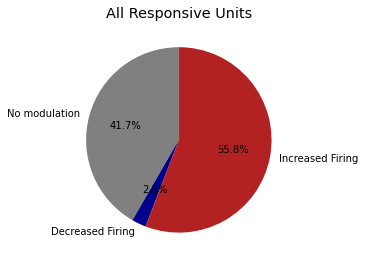

In [5]:
#### plot pie chart of individual unit responses with behavioral links

savepath = 'F:/Figure4/ActivityModulationBehavior/'
analysistype = 'All'
BLAresponses = np.loadtxt(savepath+'meanbehaviorresponses_allneurons.csv', delimiter = ',', dtype = str)[1:]
BLAresponses = BLAresponses[np.where((BLAresponses[:,3] != 'nan'))]

behaviorallylinked_pos = len(np.where((np.array(BLAresponses[:,-1], float) > .2))[0])
behaviorallylinked_neg = len(np.where((np.array(BLAresponses[:,-1], float) < -.2))[0])
notlinked = len(np.where((np.array(BLAresponses[:,-1], float) <= .2) & (np.array(BLAresponses[:,-1], float) >= -.2))[0])

fig, ax = plt.subplots(1, figsize = (5,5))

ax.pie((notlinked, behaviorallylinked_neg, behaviorallylinked_pos), startangle = 90, labels = (('No modulation', 'Decreased Firing', 'Increased Firing')), colors = ('grey', 'darkblue', 'firebrick', ), autopct = '%1.1f%%')
ax.set_title('All Responsive Units')
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(savepath+'behaviorallylinkedunits_all.svg', format = 'svg', dpi = 500, transparent = True)
#plt.savefig(savepath+'/behaviorallylinkedunits'+analysistype+'.png')

In [6]:
BLAresponses = np.loadtxt(savepath+'meanbehaviorresponses_allneurons.csv', delimiter = ',', dtype = str)[1:]

positive = BLAresponses[np.where(np.array(BLAresponses[:,-1], float) > .2)]
negative = BLAresponses[np.where(np.array(BLAresponses[:,-1], float) < -.2)]
nolink = BLAresponses[np.where((np.array(BLAresponses[:,-1], float) <= .2) & (np.array(BLAresponses[:,-1], float) >= -.2))]

positivepan = np.count_nonzero(positive[:,3] == 'panresponsive')
negativepan = np.count_nonzero(negative[:,3] == 'panresponsive')
nolinkpan = np.count_nonzero(nolink[:,3] == 'panresponsive')

totalpan = positivepan+negativepan+nolinkpan

In [7]:
BLAresponses = BLAresponses[np.where((BLAresponses[:,3] != 'nan'))]
positive = BLAresponses[np.where(np.array(BLAresponses[:,-1], float) > .2)]
negative = BLAresponses[np.where(np.array(BLAresponses[:,-1], float) < -.2)]
nolink = BLAresponses[np.where((np.array(BLAresponses[:,-1], float) <= .2) & (np.array(BLAresponses[:,-1], float) >= -.2))]

positiveuni = np.count_nonzero(positive[:,3] != 'panresponsive')
negativeuni = np.count_nonzero(negative[:,3] != 'panresponsive')
nolinkuni = np.count_nonzero(nolink[:,3] != 'panresponsive')

totaluni = positiveuni+negativeuni+nolinkuni

In [8]:
BLAresponses = np.loadtxt(savepath+'meanbehaviorresponses_allneurons.csv', delimiter = ',', dtype = str)[1:]
BLAresponses = BLAresponses[np.where((BLAresponses[:,3] == 'nan'))]
responsescorenan = np.array(BLAresponses[:,-1], float)

positivenan = len(np.unique(np.where(responsescorenan > .2)[0]))
negativenan = len(np.unique(np.where(responsescorenan < -.2)[0]))
nolinknan = len(responsescorenan) - positivenan - negativenan

totalnan = positivenan+negativenan+nolinknan

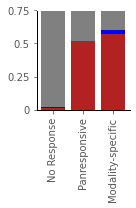

In [10]:
fig, ax = plt.subplots(1, figsize = (2,3))

ax.bar((0,1,2), (positivenan/totalnan, positivepan/totalpan, positiveuni/totaluni), color = 'firebrick')
ax.bar((0,1,2), (negativenan/totalnan, negativepan/totalpan, negativeuni/totaluni), bottom = (positivenan/totalnan, positivepan/totalpan, positiveuni/totaluni), color = 'blue')
ax.bar((0,1,2), (nolinknan/totalnan, nolinkpan/totalpan, nolinkuni/totaluni), bottom = ((positivenan+negativenan)/totalnan, (positivepan+negativepan)/totalpan, (positiveuni+negativeuni)/totaluni), color = 'gray')

ax.set_facecolor('white')
ax.grid(False)
ax.set_ylim(0,.75)
ax.set_yticks((0,.25,.5,.75))
ax.set_yticklabels((0,.25,.5,.75))
ax.set_xticks((0,1,2))
ax.set_xticklabels(('No Response', 'Panresponsive', 'Modality-specific'), rotation = 90)
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')

plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure4/neurontypesmodulated.svg', format = 'svg', dpi = 500, transparent = True)

In [82]:
savepath

'F:/Figure4/ActivityModulationBehavior/'